In [1]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import math

# <span style="color:orange"> Numerical Simulation Laboratory: Lecture 02 </span>

## Exercise 1

In this exercise we test the importance-sampling method to estimate the integral:$$I:=\int_0^1\dfrac{\pi}{2}\cos\biggl(\dfrac{\pi}{2}x\biggr)\,dx\equiv\int_0^1f(x)\,dx$$ which can be analytically solved $I=1$.

### Uniform sampling

In the first part we sample the interval $[0,1]$ with a uniform distribution generating $M=10^6$ numbers $\{x_k\}$ divided into $N=100$ blocks of equal length $L=M/N$. From the $\ell$-th block we get the estimation:$$I_\ell\approx \dfrac{1}{L}\sum_{k=1+(\ell-1)L}^{\ell L}f(x_k)$$ and then combine them using the blocking method (implemented, as usual, in the library `blocking_method.h`).

#### Code 
The C++ code we used to carry out the estimation is organized in the following fashion.


An abstract class <code>function</code>:
```C++
class function{
    public:
    virtual void SetParameter(char c, double p) =0;
    virtual double GetParameter(char c) const =0;
	virtual double operator()(double x) const =0;
};
```
from which we derive the class <code>cosine : public function</code> representing our integrand function and the classes that stand for the PDFs.

Another abstract class <code>Importance_Sampling</code> whose methods carry out the integration. 
```C++
class Importance_Sampling{
    const function * m_f;        // integrand function
	double m_sum;
	unsigned int m_niter, m_nblocks, m_L;
	double * m_ave, * m_aveprog, * m_err;

	protected:
	Random gen;
	double m_a, m_b;
	function * m_p;              // PDF
	virtual double Generate() { return -1; }; 	
    // not set to zero just to make the Run() method work, should not be used in this form

	public:
	// constructor(s)
	Importance_Sampling();
	// methods to access private members
	void Set_distrib_params(char c, double p) { m_p->SetParameter(c, p); }; 
	unsigned int Get_Nsteps() const { return m_niter; };
	unsigned int Get_Nblocks() const { return m_nblocks; };
	double Get_Estimate() const;
	double Get_Error() const;
	double * Get_Estimate_Prog() const { return m_aveprog; };
	double * Get_Error_Prog() const { return m_err; };
	// evaluating integrals
	void Run(const function* f, unsigned int nsteps, unsigned int nblocks);
};
```

Each derived class represents a particular choice of PDF and the method `double Generate()` is implemented accordingly. The constructors take care of assigning an istance of the corresponding class to the pointer `m_p`. In the current case we will use the class `IS_Uniform : public Importance_Sampling`.
#### Results

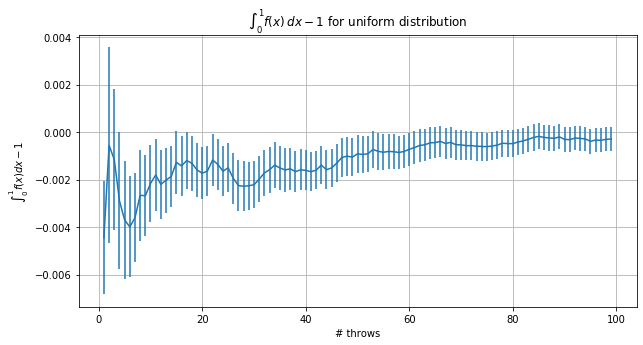

In [3]:
file=open("Es_lezione_02/dataEx2_1.dat")
line1=file.readline().split()
M=int(line1[0])
N=int(line1[1])
x=np.arange(1,N)
ave=np.zeros((2, N-1))
err=np.zeros((2, N-1))
i=0

for line in file.readlines():
    for j in range(2):
        ave[j, i]=float(line.split()[j])
        err[j, i]=float(line.split()[j+2])
    i+=1
    
file.close()
    
plt.errorbar(x,ave[0],yerr=err[0])
plt.xlabel('# throws')
plt.ylabel('$\int_0^1 f(x) dx-1$')
plt.title("$\int_0^1 f(x)\, dx-1$ for uniform distribution")
plt.grid(True)
plt.rcParams["figure.figsize"]=(10,5)
plt.show()

We see that the estimation seems to converge to the expected value and, approximately from $N=60$, the two numbers are compatible. Note that the order of magnitude of the uncertainty is roughly 0.0005 at the end of the simulation. 

### Importance sampling

According to the importance-sampling theory, we expect to minimize the variance if we extract the points from a distribution that most resembles the function on the integral domain (provided it is positive in that set and that is the case in our example). This "maximum-resemblance" approach has, however, a drawback: if we want to generate numbers according to the new distribution efficiently (i.e. using the inversion methd) we cannot use a probability density whose analytic form is too complicated (because the inversion of the cumulative function will turn out to be non trivial). 

As a first guess we use a linear distribution whose density is the form $D(x)=N(1-x)$. The normalization is an immediate calculation which yields $N=2$. 
The integral can clearly be rewritten as:
$$
\int_0^1f(x)\,dx=\int_0^1\dfrac{\pi}{4}\dfrac{\cos\bigl(\frac{\pi}{2}x\bigr)}{1-x}\,2(1-x)d x\equiv \int_0^1\bar{f}(x)\,D(x)dx
$$
i.e. we can reach our goal by applying the Monte-Carlo method by evaluating the average of function $\bar{f}$ over a set of points $\{x_i\}$ distributed according to $D$. 
The simple analytic expression of $D$ is chosen so that the points $\{x_i\}$ can be easily obtained from a sample $\{y_i\}$ uniformly-distributed in $(0,1)$ by the inversion-function method:
$$x_i=1-\sqrt{1-y_i}$$
The importance sampling for a linear PDF is implemented in the class `class IS_Linear : public Importance_Sampling`.

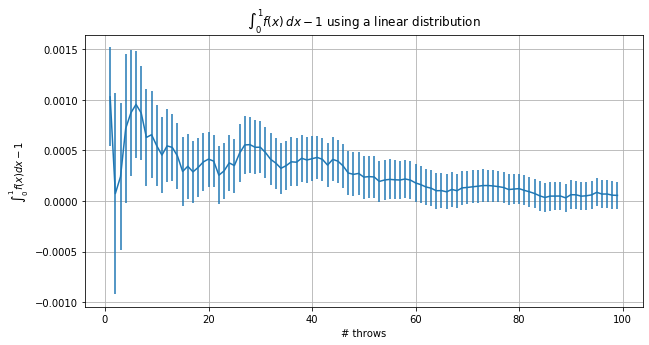

In [4]:
plt.errorbar(x, ave[1], yerr=err[1])
plt.xlabel('# throws')
plt.ylabel('$\int_0^1 f(x) dx-1$')
plt.title("$\int_0^1 f(x)\, dx-1$ using a linear distribution")
plt.grid(True)
plt.rcParams["figure.figsize"]=(10, 5)
plt.show()

The number of blocks it takes for the estimation to reach compatibility with the expected value (i.e. the two numbers are closer than the estimated uncertainty) is essentially unchanged from the previous case but the scaling of the $y$-axis shows at first sight that both the estimations (as compared to the expected value) and the uncertainties are much smaller than the ones from the uniform sampling.

## Exercise 2
Here we simulate two 3D random walks, one on a cubic lattice of constant $a=1$ and one in free, isotropic space:
- In the first process we set a random walker bound to the lattice in the origin and let it wander through it so that he can "choose" both the direction ($x,y$ or $z$) and whether to jump in the positive or negative direction of it of a single unit cell in each step. Both the choice of the direction and the orientation of the leap are completely random (i.e. he is equally likely to move in the $x$ direction as he is to move in any of the other two).
- In the second process we set an unbound random walker in the origin and let it roam by making jumps of magnitude $a=1$ in a direction isotropically-selected and specified by its polar angles $\vartheta\in(0,\pi)$ and $\varphi\in(0,2\pi)$ (in a spherical-coordinate system centered in the current position of the walker).

We run $M=10^4$ simulations of both processes for a number of $S=100$ random-walk steps and we extract the square root of the average squared distance from the origin as a function of the number of steps $n=1,\dots, S$. To esimate the statistical uncertainty on this quantity we once again use the blocking method with $N=100$ blocks.

### Code

The implementation in C++-code of the two types of RWs code has been carried out respectively via the methods `Cubic_Lattice()` and `Isotropic_Space()` from the class:
```C++
class Random_Walk3D{
	Posizione m_x;			   // position of the walker
	unsigned int m_nsteps;		// # of steps
	double m_a;			      // average distance per step
	double * m_distance;		// saves distance from starting point in each step
	Random gen;

	public:	
	// constructors
	Random_Walk3D(unsigned int nsteps, double a);
	Random_Walk3D(Posizione x0, unsigned int nsteps, double a);
	Random_Walk3D(double x0, double y0, double z0, unsigned int nsteps, double a);
	// destructor
	~Random_Walk3D();
	// methods to access private members
	void Set_Nsteps(unsigned int nsteps);
	void Set_Start(Posizione x0) { m_x=x0; };
	void Set_Start(double x0, double y0, double z0) { m_x.SetXYZ(x0, y0, z0); };
	void Set_to_zero();
	void Set_x_to_zero() {	m_x.SetXYZ(0., 0., 0.); };
	void Set_distance_to_zero();
	double * Get_distance() const { return m_distance; };
	Posizione Get_x() const { return m_x; };
	// 3d random walks
	void Cubic_Lattice();
	void Isotropic_Space();
};
```
which uses in its private members an istance of the class:
```C++
class Posizione{
	double m_1, m_2, m_3;     // coordinates

	public:
	// constructors;
	Posizione();
	Posizione(double, double, double);
	// methods:
	double GetX() const {return m_1;};
	double GetY() const {return m_2;};
	double GetZ() const {return m_3;};
	double GetR() const {return sqrt(pow(m_1,2)+pow(m_2,2)+pow(m_3,2));};
	double GetRho() const {return sqrt(pow(m_1,2)+pow(m_2,2));};		
	double GetPhi() const {return atan2(m_2,m_1);};
	double GetTheta() const {return acos(m_3/GetR());};		
	double Distance(const Posizione& p ) const {return sqrt(pow(GetX()-p.GetX(),2)+pow(GetY()-p.GetY(),2)+pow(GetZ()-p.GetZ(),2));};
	void SetComponent(unsigned int i, double val);
	void SetXYZ(double, double, double);
	void Set_to_zero();
	// algebra
	Posizione& operator=(const Posizione &);
	Posizione operator+(const Posizione&);
	Posizione operator-(const Posizione&);
	Posizione& operator+=(const Posizione&);
};

```
representing a point in 3-space.
### Results

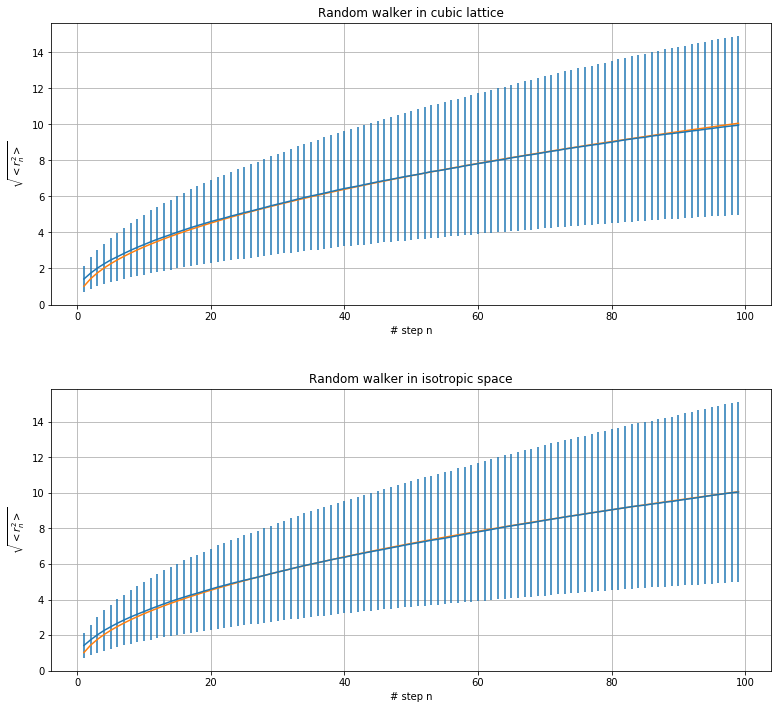

Fit parameters: 
1. Cubic lattice:  k_1 = 1.0105015122360501  +/-  1.594260166667937e-06
2. Free space:     k_2 = 1.0119102564620301  +/-  1.365918296265051e-06


In [67]:
from scipy.optimize import curve_fit

def f(x, k):
    return k*np.sqrt(x)

file=open("Es_lezione_02/dataEx2_2.dat")
line1=file.readline().split()
S=int(line1[0])                  
x=np.arange(1,S)
ave=np.zeros((2, S-1)) 
err=np.zeros((2, S-1))
i=0

for line in file.readlines():
    for j in range(2):
        ave[j, i]=float(line.split()[j])
        err[j, i]=float(line.split()[j+2])
    i+=1
    
file.close()

p_opt1, p_cov1=curve_fit(f, x, ave[0], 1)
p_opt2, p_cov2=curve_fit(f, x, ave[1], 1)

y1=f(x, p_opt1[0])
y2=f(x, p_opt2[0])

f, canvas=plt.subplots(2)
titles=['Random walker in cubic lattice', 'Random walker in isotropic space']

for j in range(2):
    canvas[j].errorbar(x, ave[j], yerr=err[j])
    canvas[j].set(xlabel='# step n', ylabel='$\sqrt{< r^2_n>}$')
    canvas[j].set_title(titles[j])
    canvas[j].grid(True)

canvas[0].plot(x, y1)
canvas[1].plot(x, y2)
    
plt.subplots_adjust(left=0.2, bottom=-0.6, right=1.2, top=1.2, wspace=0.2, hspace=0.3)
plt.show()

print("Fit parameters: ")
print("1. Cubic lattice:  k_1 = " + str(p_opt1[0]) + "  +/-  " + str(p_cov1[0][0]))
print("2. Free space:     k_2 = " + str(p_opt2[0]) + "  +/-  " + str(p_cov2[0][0]))

We see that both curves are very well fitted by a function of the form $f(n)=k
\sqrt{n}$ for $k\approx 1$; actually, as $n$ grows, the function and the data become more and more alike. 

Both results could be predicted from the diffusive nature of the random walk process: in the continuum limit we know that the probability distribution $\rho$ obeys the diffusion equation: $$\dfrac{\partial\rho}{\partial t}=D\,\triangle\rho$$ where $\triangle$ is the Laplace operator. A solution to this equation in the space of tempered distribution with boundary condition $\rho(\vec{x},0)=\delta_0$ (i.e. the walker starts from the origin, as in our simulations) is easily evaluated by Fourier-transform $$\rho(\vec{x},t)=\dfrac{1}{(4\pi Dt)^{3/2}}\exp\biggl[-\dfrac{\lVert\vec{x}\rVert^2}{4Dt}\biggr]$$
(an isotropic normal distribution with variance increasing in time as a description of the walker being more likely to get farther and father from the origin as time passes). As a straightforward consequence we evaluate the second central moment $\sigma^2=2Dt$, which corresponds to the expected value of $\lVert \vec{x}\rVert^2$ since $\langle\lVert \vec{x}\rVert\rangle=0$.

$t$ is clearly a linear function of the step $n$: if $\tau$ is the average time it takes to make a move we have $t=\tau n$, while the diffusion constant $D$ is given by $D=a^2/(2\tau)$. Substituting into the expected behaviour of $\sigma$ we get:
$$ \sigma\equiv\sqrt{\langle\lVert \vec{x}\rVert^2\rangle}=a\sqrt{n}$$
which is exactly what we got as we set $a=1$ in both simulations.

The fact that $f$ does not fit the points for small $n$ as well as it does for large value of the number of step is a consequence of having described a discrete variable in term of a continuous one: at a global scale, a leap of magnitude $a$ is huge when few other steps have been made but becomes very tiny as the walker progresses, so the continuum limit gives us a legit approximation for larger values of $n$.